<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#KPSS-&amp;-ADF-tests" data-toc-modified-id="KPSS-&amp;-ADF-tests-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>KPSS &amp; ADF tests</a></span></li><li><span><a href="#Спектр-(преобразование-Фурье)" data-toc-modified-id="Спектр-(преобразование-Фурье)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Спектр (преобразование Фурье)</a></span></li><li><span><a href="#Изучение-ACF-и-PACF" data-toc-modified-id="Изучение-ACF-и-PACF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Изучение ACF и PACF</a></span></li><li><span><a href="#Изучение-формы-сезонности" data-toc-modified-id="Изучение-формы-сезонности-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Изучение формы сезонности</a></span></li><li><span><a href="#Изучение-формы-тренда" data-toc-modified-id="Изучение-формы-тренда-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Изучение формы тренда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression-with-feautures" data-toc-modified-id="Linear-Regression-with-feautures-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression with feautures</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Holt-Winters" data-toc-modified-id="Holt-Winters-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Holt Winters</a></span></li><li><span><a href="#STL-Forecast" data-toc-modified-id="STL-Forecast-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>STL Forecast</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Facebook Prophet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#ВЫВОД" data-toc-modified-id="ВЫВОД-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ВЫВОД</a></span></li><li><span><a href="#Рекомендации" data-toc-modified-id="Рекомендации-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Рекомендации</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime as dt
import numpy as np
import seaborn as sns
from numpy.random import RandomState
from pylab import rcParams
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from datetime import datetime, time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.fft import fft, fftfreq

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm, notebook


from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from prophet import Prophet


ModuleNotFoundError: No module named 'lightgbm'

In [55]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 2007

<Figure size 864x576 with 0 Axes>

In [3]:
## ФУНКЦИИ для изучения данных (пропуски, нули, корреляции, типы данных)

# сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

    
##  Функция для определения выбросов (по методу IQR или 3s) и их удаления
### анализируется столбец column и смотрится распределение значений и удаляются выбросы
def calc_bounds_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    
    t1 = df[column].describe()
    if mode == 'iqr':
        iqr = t1['75%']-t1['25%']
        l_bound = max(t1['25%'] - iqr*k_lbound, t1['min'])
        u_bound = min(t1['75%'] + iqr*k_ubound, t1['max'])
    else:
        l_bound = t1['mean'] - 3*t1['std']
        u_bound = t1['mean'] + 3*t1['std']
    
    return l_bound, u_bound

def show_table_outliers(df, col, mode='iqr', k=3):
    cnt = df.shape[0]
    r = []
    for col in df.select_dtypes(exclude=[object]).columns:
        lbound, ubound = calc_bounds_outliers(df, col, mode=mode, k_lbound=k, k_ubound=k)
        l_out_cnt = len(df[df[col] < lbound])
        u_out_cnt = len(df[df[col] > ubound])
        r.append([col, lbound, ubound, l_out_cnt, u_out_cnt, (l_out_cnt + u_out_cnt)/cnt*100])
    print(f'\nOutliers detection: mode = {mode}, k = {k}')
    display(pd.DataFrame(data=r, columns=['column', 'lbound', 'ubound', 'l_out', 'u_out', 'total_%_out']))


# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
   
    # статистики
    display('Числовые поля', df.describe(include=[np.number]).transpose())
    

In [163]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def make_features(data, index_feautures, lags, rolling_mean_size):
    enhanced_data = data.copy()
    if 'Y' in index_feautures:
        enhanced_data['year'] = enhanced_data.index.year
    if 'M' in index_feautures:
        enhanced_data['month'] = enhanced_data.index.month
    if 'D' in index_feautures:
        enhanced_data['day'] = enhanced_data.index.day
    if 'H' in index_feautures:
        enhanced_data['hour'] = enhanced_data.index.hour
    if 'WD' in index_feautures:
        enhanced_data['dayofweek'] = enhanced_data.index.dayofweek
    if 'YW' in index_feautures:
        enhanced_data['weekofyear'] = enhanced_data.index.weekofyear
    
    if type(enhanced_data) == pd.Series:
        enhanced_data = enhanced_data.to_frame()

    data_column = enhanced_data[enhanced_data.columns[0]]
    
    for lag in lags:
        enhanced_data['lag_{}'.format(lag)] = data_column.shift(lag)

    enhanced_data['rolling_mean'] = data_column.shift().rolling(rolling_mean_size).mean()
    return enhanced_data

def plot_cum_rmse(t):
    cs = [np.nan]
    for i in range(1,len(t)):
        cs.append(RMSE(t.iloc[:i,0], t.iloc[:i,1]))
    t['rmse_cum'] = cs
    ax = t['rmse_cum'].plot(xlabel='points', ylabel='RMSE')
    ax.set_title('Change RMSE on adding points')
    
    print('RMSE:', RMSE(t[0], t[1]))
    print('MAE:', mean_absolute_error(t[0],t[1]))
    print('MeanError:', np.mean(t[0]-t[1]))
    plt.show()

In [60]:
# Тест стационарности ряда (ADF и KPSS)
def test_stationarity(ts):
    statistic, p_value, n_lags, nobs, critical_values, icbest = adfuller(ts, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

    print(f'ADF\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is not stationary).\n\tH1 accepted: The data is stationary around a trend\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is not stationary).\n-----------------------\n')



    statistic, p_value, n_lags, critical_values = kpss(ts, regression='ct', nlags='legacy', store=False)
    print(f'KPSS\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    # print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n-----------------------\n')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is stationary around a trend).\n\tH1 accepted: The data is not stationary\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is stationary around a trend).\n-----------------------\n')

# make FastFurierTransform & evaluate main periods
def fft_periods(sgnl):
    # длина ряда
    N = len(sgnl)

    # период 
    #(можно ввести T=1.0/24.0, но это будет немного менее удобно)
    T = 1.0

    # быстрое преобразование Фурье 1D
    yf = fft(sgnl)
    xf = fftfreq(N, T)[:N//2]

    # коэффициент мощности
    power = 2.0/N *np.abs(yf[0:N//2])

    # График спектра
    plt.plot(xf[1:], power[1:])
    # plt.grid()
    plt.show()

    # Соберем фрейм с периодами и коэффициентами мощности
    t = pd.DataFrame(data={
        'period': 1/xf[1:],
        'power': power[1:]
    })

    # np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    # Выберем TOP n и построим гистограмму (barh)
    n=20
    tN = t[t['period']<N//2].sort_values(by='power').tail(n).sort_values(by='period')
    tN.plot.barh(y='power', x='period', ylabel='period', title=f'TOP{n} periods')
    plt.show()

# Построение графиков ACF и PACF    
def tsplot(y, lags=None, figsize=(18, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

#         print("Критерий Дики-Фуллера: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

In [3]:
data = pd.read_csv('..\\..\\datasets\\taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [7]:
# проверим на монотонность индекса даты и если необходимо, отсортируем
if ~data.index.is_monotonic:
    data.sort_index(inplace=True)
    
# ресемплинг по 1 часу (в сутках 24 точки)
data = data.resample('1H').sum()
dataD = data.resample('1D').sum()

In [8]:
# Изучим данные
evaluate_df(data, False, False, False)


------SAMPLE--------


,num_orders
datetime,
2018-07-20 23:00:00,168
2018-03-28 16:00:00,84
2018-08-26 15:00:00,142
2018-04-23 01:00:00,74
2018-07-29 20:00:00,114



------DTYPES--------
num_orders    int64
dtype: object


------NaN & zero--------
           NA  filled  zero %na
num_orders  -    4416     1   -


'Числовые поля'

,count,mean,std,min,25%,50%,75%,max
num_orders,"4,416.000",84.423,45.024,0.000,54.000,78.000,107.000,462.000


Есть один ноль в данных. Это нужно будет учитывать при выборе модели

<AxesSubplot:xlabel='datetime'>

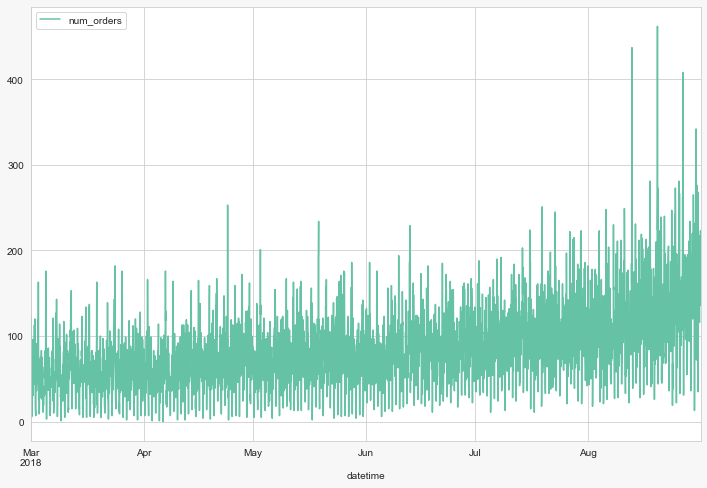

In [9]:
# построим график временного ряда
data.plot()

Проверим, что в данных нет пропусков (пропущенных часов). Для этого посчитаем сколько должно быть часов между МАКС и МИН часами и сравним сколько записей мы по факту имеем.

In [21]:
data.index[-1]-data.index[0]

Timedelta('183 days 23:00:00')

In [22]:
# Число часов в наблюдениях, которое должно быть
183*24+23+1

4416

In [23]:
# Фактическое число часов
len(data)

4416

#### Вывод:

В данных нет пропусков, есть одно нулевое значение. Видны выбросы в последних месяцах данных, это вероятно приведет к более высокому RMSE на тесте по сравнению с валидацией



## Анализ

Проверим тестами стационарность ряда около тренда

### KPSS & ADF tests
The hypotheses for the ADF (Augmented Dickey-Fuller) test for non stationarity<br>
* H0: The data is not stationary
* H1: The data is stationary around a trend
<br><br>

The hypotheses for the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test for stationarity<br>
* H0: The data is stationary around a trend
* H1: The data is not stationary


ADF has high risk of error II type (to not reject false H0). ADF often define non stationary series as stationary

In [10]:
test_stationarity(data)

ADF
----------------------
Statistic: -8.326521572379825
p-value: 1.2583924361803328e-11
num lags: 30
Critial Values:
   1% : -3.960836041046122
   5% : -3.4114917019432394
   10% : -3.127639850914672
Result:
	H0 rejected (H0: The data is not stationary).
	H1 accepted: The data is stationary around a trend
-----------------------

KPSS
----------------------
Statistic: 1.1696420622956867
p-value: 0.01
num lags: 31
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result:
	H0 rejected (H0: The data is stationary around a trend).
	H1 accepted: The data is not stationary
-----------------------



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Получилось противоречивое нечто. 

ADF тест сказал, что это **точно стационарный** ряд около тренда (вероятность нестационарности 1Е-11), <br>KPSS тест  показал, что это **точно не стационарный** тест (вероятность стационарности менее 1%, примерно 1Е-9)

Ну считаем ряд нестационарным тогда.

### Спектр (преобразование Фурье)

Используем быстрое преобразование Фурье для выделения основных частот, присутствующих во временном ряде

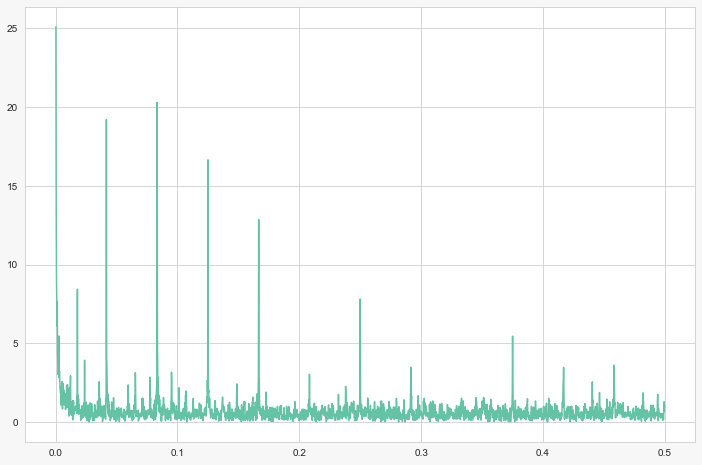

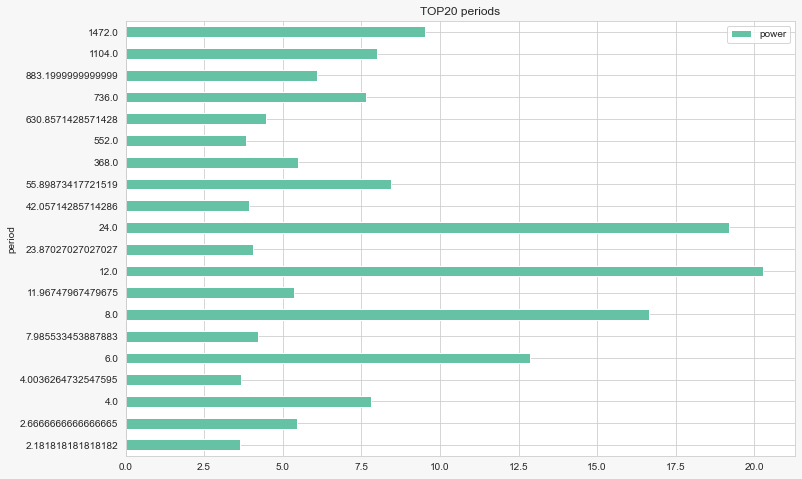

In [11]:

# Выделяем временной ряд как np.array
sgnl = data.iloc[:,0].values

fft_periods(sgnl)



В спектре имеются гармоники с периодами 4, 6, 8, 12, 24 часов, берем периодичность 24ч (как раз сутки), остальные периодичности будут просто профилем сезонности
Интересно, что нет недельной сезонности (168 часов)

### Изучение ACF и PACF

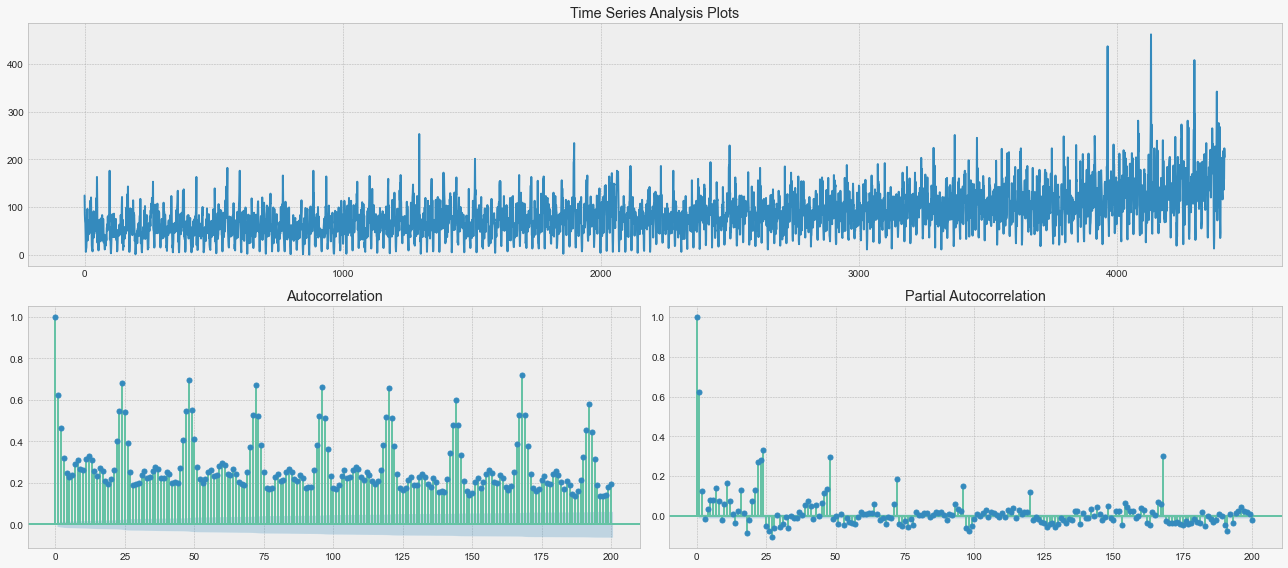

In [61]:
tsplot(sgnl, lags=200)

Видим сильную корреляцию на PACF с лагом 168 (неделя)

Посмотрим в чем причина, почему FFT не заметил сезонности недельной.

Для этого, построим график недельных профилей по часам (часы сгруппированы по 2 чтобы было ментгше шумов и более наглядно

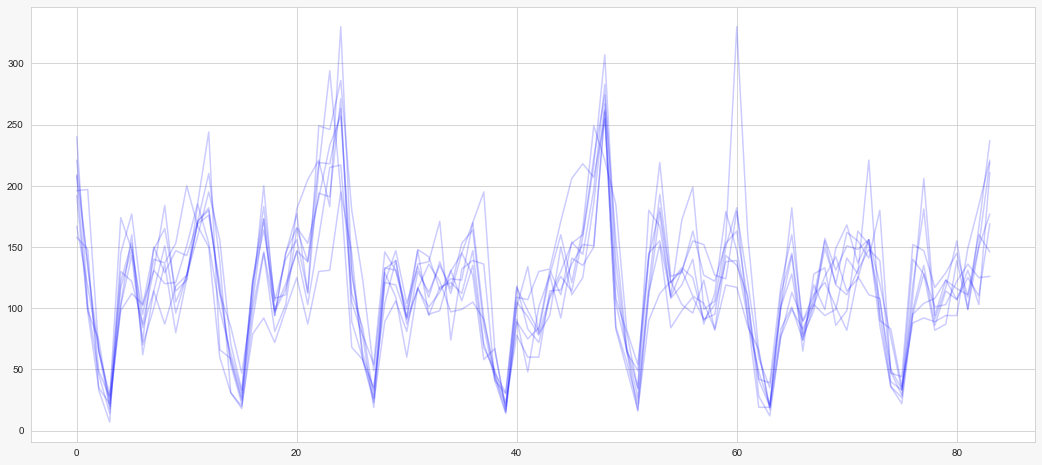

In [15]:
h=2
fig, ax = plt.subplots(figsize=(18,8))
for i in range(8):
    ax.plot(data.resample(str(h)+'H').sum().iloc[int(i*24*7/h):int((i+1)*24*7/h), 0].values, color='b', alpha=0.2)

Как видим, профиль дней зависит от дня недели. Но при этом, общий уровень остается примерно тем же. Именно поэтому, FFT и не нашел сезонности 168ч. FFT хорошо ищет аддитивные сезоннности, пример:

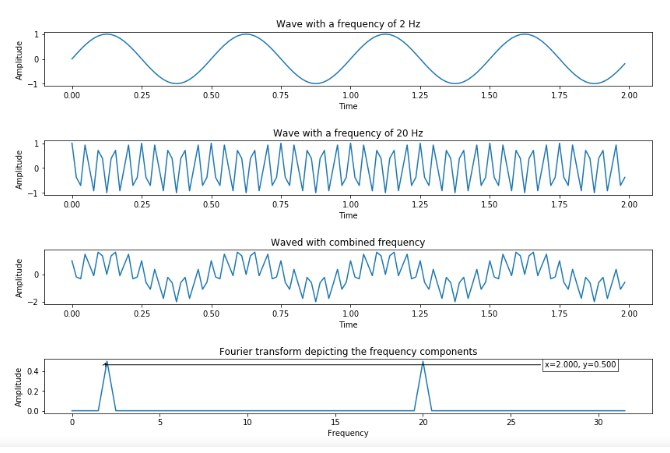

In [59]:
PERIOD = 168

### Изучение формы сезонности

Посмотрим как изменяется форма сезонности

Можно использовать seasonal_decompose из пакета statsmodels для определения типа сезонности
- Если сезонность аддитивная, то abs residuals будут уменьшаться при model='multiplicative' и стабильной при model='additive'
- Если сезонность мультипликативная, то то abs residuals будут стабильными при model='multiplicative' и расти при model='additive'

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

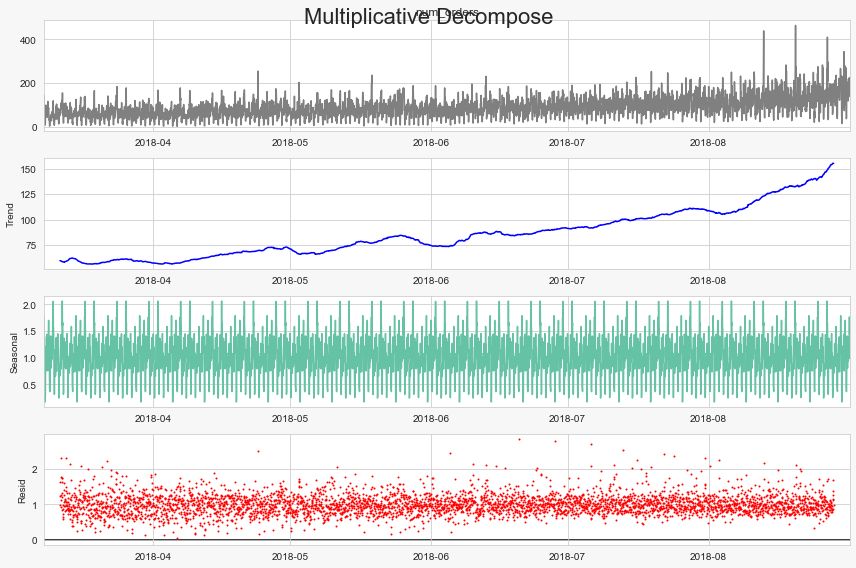



Если сезонность мультипликативная, то на этом графике мы увидим стабильный уровень


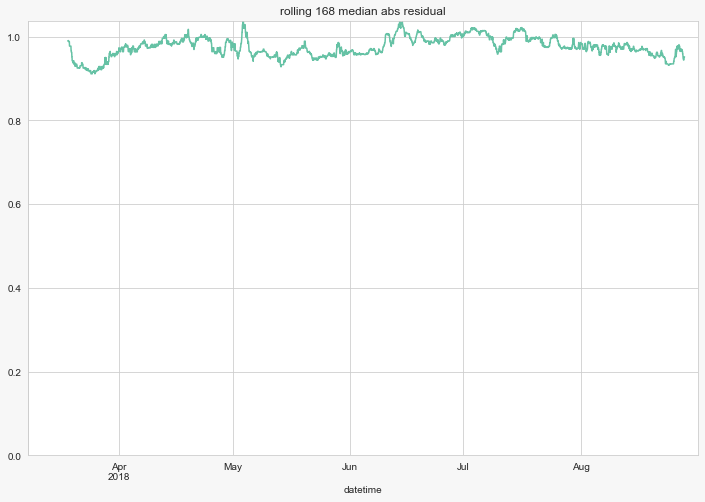

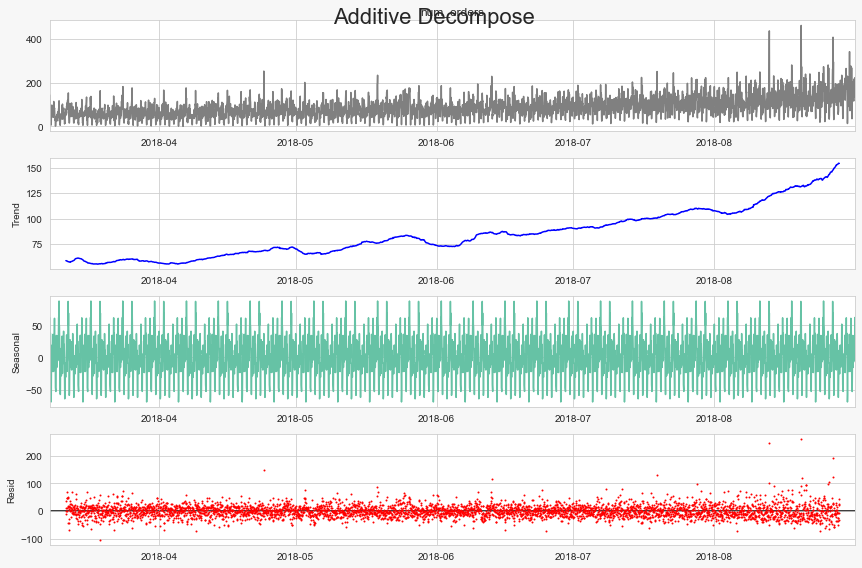



Если сезонность аддитивная, то на этом графике мы увидим стабильный уровень


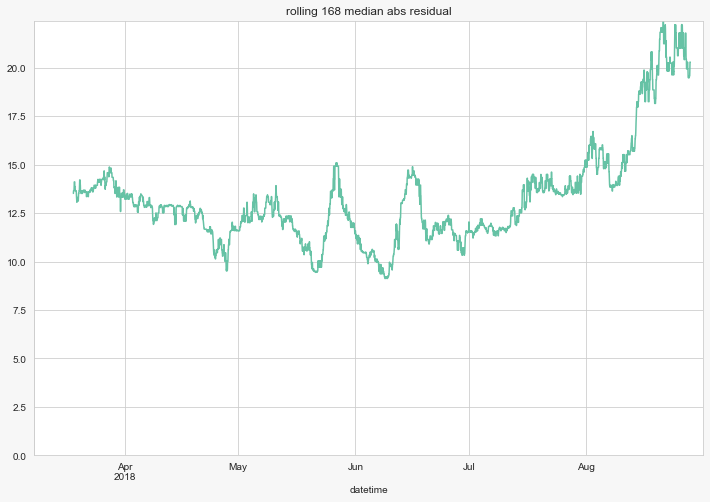

In [152]:
def mad(x):
    return np.median(np.fabs(x))

# Multiplicative Decomposition 
result_mul = seasonal_decompose(y+1, model='multiplicative',period = 168)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 168)

# Plot
fig = result_mul.plot()
fig.suptitle('Multiplicative Decompose', fontsize=22)

fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)
plt.show()
# result_mul.resid.rolling(window=PERIOD, min_periods=0).std().plot(legend="rolling "+str(PERIOD)+" std residual")

print('\n\nЕсли сезонность мультипликативная, то на этом графике мы увидим стабильный уровень')
mmde = result_mul.resid.rolling(window=PERIOD, min_periods=0).apply(mad, raw=True)
mmde.plot(title="rolling "+str(PERIOD)+" median abs residual", ylim=(0,max(mmde.dropna())))
plt.show()

fig = result_add.plot()
fig.suptitle('Additive Decompose', fontsize=22)
fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)
plt.show()

print('\n\nЕсли сезонность аддитивная, то на этом графике мы увидим стабильный уровень')
# result_add.resid.rolling(window=PERIOD, min_periods=0).std().plot(title="rolling "+str(PERIOD)+" std residual")
mmde = result_add.resid.rolling(window=PERIOD, min_periods=0).apply(mad, raw=True)
mmde.plot(title="rolling "+str(PERIOD)+" median abs residual", ylim=(0,max(mmde.dropna())))
plt.show()

Видим, что сезонность явно не аддитивная. Скорее ближе к мультипликативной


### Изучение формы тренда

Посмотрим как изменяется тренд. Посмотрим подневные данные

<AxesSubplot:xlabel='datetime'>

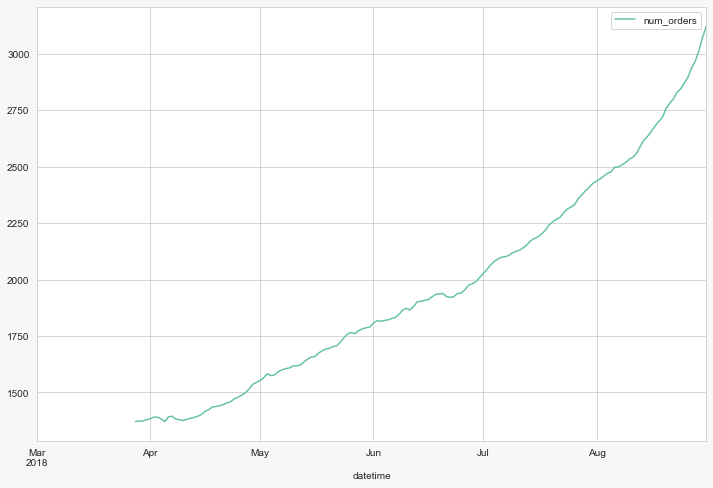

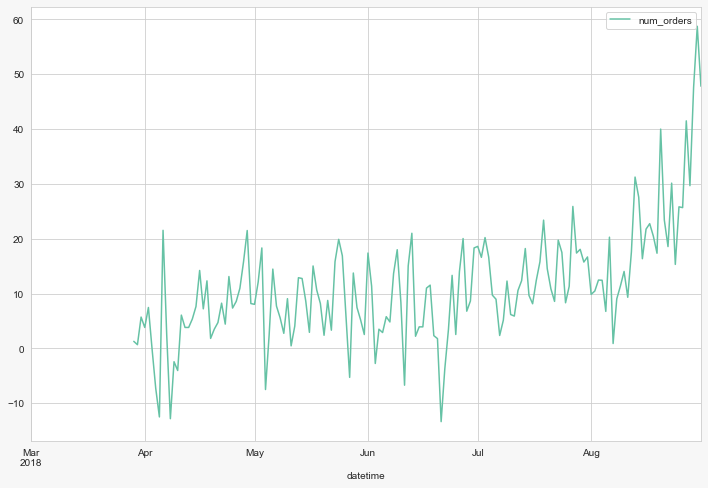

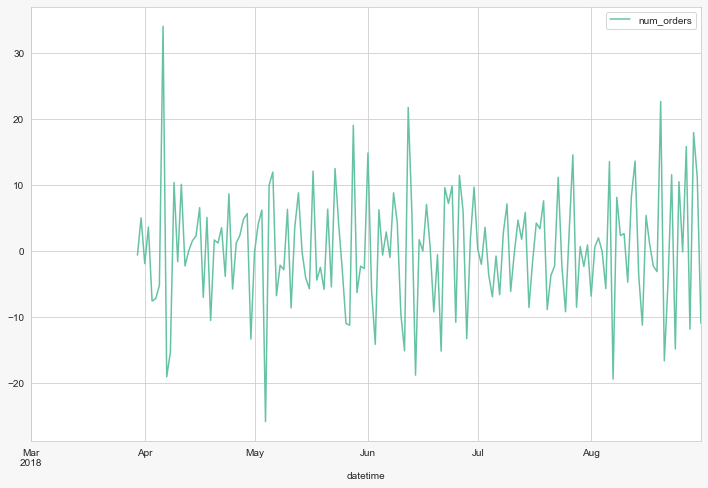

In [191]:
dataD.rolling(28).mean().plot()
dataD.diff(1).rolling(28).mean().plot()
dataD.diff(1).diff(1).rolling(28).mean().plot()



Тренд нелинейный, степенной (две разности привели уровень тренда в около нулевому положению), возрастающий

## Обучение

Добавим новые фичи

In [194]:
enhanced_data = make_features(
    data, 
    ['WD'], 
    np.concatenate([np.arange(1,25),[168]]), 
    24)
#  Фичи содержат лаг=1, т.е. на 1 час назад данные, т.е.
## модель при прогнозе делает прогноз на 1 час вперед, 
## используя каждый раз свежие данные

train, test = train_test_split(enhanced_data.dropna(), shuffle=False, test_size=0.1)
train = train.dropna()

target_name = enhanced_data.columns[0]

X_train = train.drop(columns=[target_name])
y_train = train[target_name]
X_test = test.drop(columns=[target_name])
y_test = test[target_name]
X = enhanced_data.dropna().drop(columns=[target_name])
y = enhanced_data.dropna()[target_name]
N = X.shape[0]
test_start = int(N*0.9)
valid_start = int(N*0.9*0.9)

display('Train&Test shapes', 
        pd.DataFrame(
            data={
                'train': [X_train.shape, len(y_train)], 
                'test': [X_test.shape, len(y_test)] },
            index=['X', 'y']
        )
       )
print(f'valid_start:\t{valid_start}\ntest_start:\t{test_start}\nN:\t\t{N}\nvalid_size =\t{test_start-valid_start}\ntest_size  =\t{N-test_start}')

'Train&Test shapes'

,train,test
X,"(3823, 27)","(425, 27)"
y,3823,425


valid_start:	3440
test_start:	3823
N:		4248
valid_size =	383
test_size  =	425


### Linear Regression with feautures

In [162]:
%%time

model = LinearRegression().fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("rmse обучающей выборки:",  RMSE(y_train, y_train_pred))
print("rmse тестовой выборки: ",  RMSE(y_test, y_test_pred))

rmse обучающей выборки: 25.796831550871154
rmse тестовой выборки:  39.10688706876293
Wall time: 8.01 ms


В данном случае мы делаем fit модели на train выборке и далее делаем прогнозы для каждого test наблюдения, но при этом для каждого наблюдения мы используем фичи, в т.ч. с лагом 1 (значение таргета на прошлом шаге), т.е. при прогнозе на следующий шаг мы используем данные за текущий шаг и более ранние шаги. Но тогда мы могли бы заново запустить fit и обучить модель на более свежих данных. Это должно помочь улучшить test.

Такой подход будет более долгим, но результат должен стать получше. Особенно критично для моделей типа ES, STLForecast, которые активно обучаются именно на последних данных.

Выделим сначала из train фолд обучения и валидации по индексу valid_start

  0%|          | 0/383 [00:00<?, ?it/s]

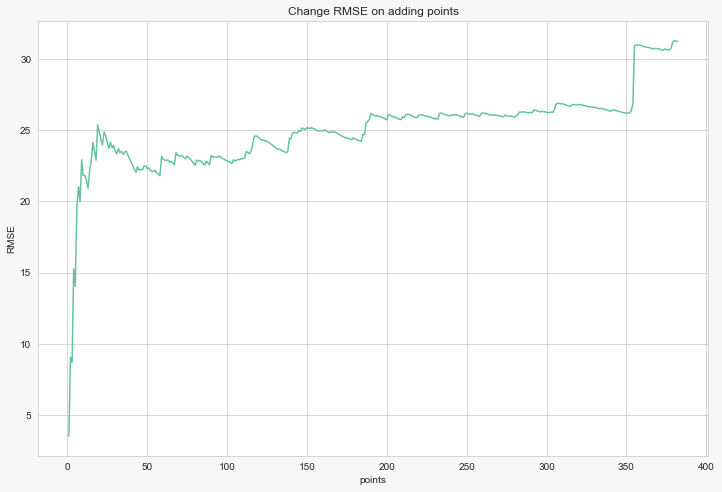

RMSE: 31.212277787486112
MAE: 21.900817245845616
MeanError: -0.11963381445582785


In [159]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = LinearRegression().fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    valid_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

И посчитаем на тесте метрики, чтобы сравнить

  0%|          | 0/425 [00:00<?, ?it/s]

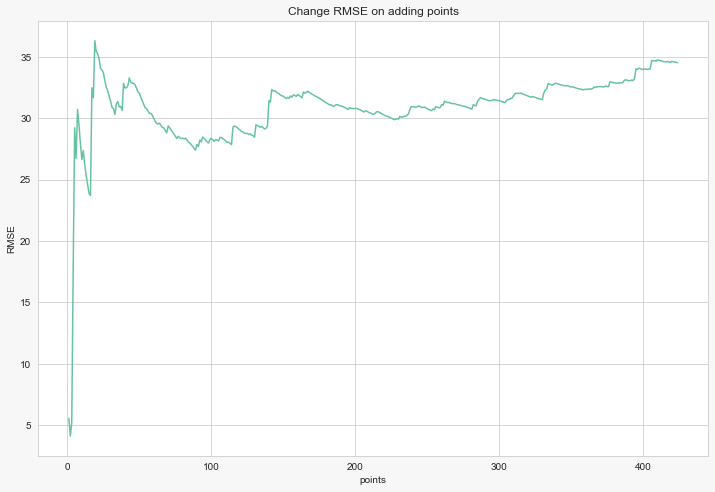

RMSE: 34.49225119755959
MAE: 25.424244514511045
MeanError: 3.8717012847869783


In [160]:
test_forecast = []
for i in notebook.tqdm(range(test_start, N)):
    # fit model
    model_fit = LinearRegression().fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    test_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(test_forecast))

Как видим, тест действительно немного улучшился, но хотя baseline и побит, мы попробуем и другие модели проверить на валидации и только лучшую запустим в тест уже.

### LGBM

  0%|          | 0/383 [00:00<?, ?it/s]

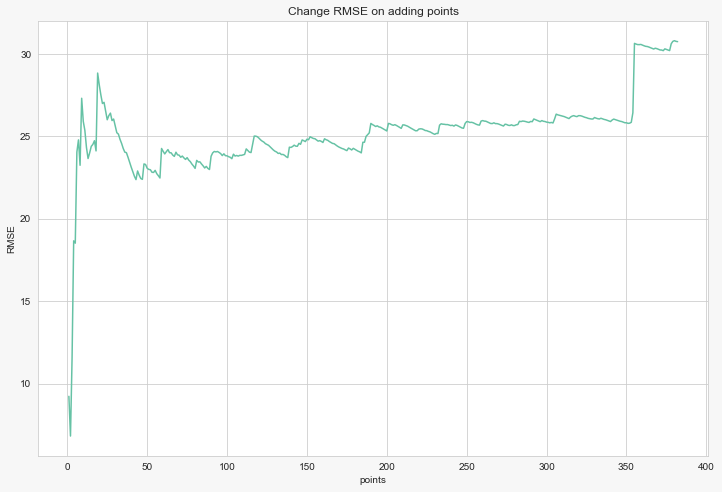

RMSE: 30.704158900895248
MAE: 21.058484141686893
MeanError: 1.9664736915187535


In [51]:


valid_forecast = []
params = {
    'verbose':-1,
    'max_depth': 5,
    'num_iterations': 60,
    'colsample_bytree': 0.85,
    'reg_alpha': 5.5,
    'seed': 38
}

lgb_booster = LGBMRegressor(**params)

for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = lgb_booster.fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    valid_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### SARIMA

Критерий Дики-Фуллера: p=0.000057


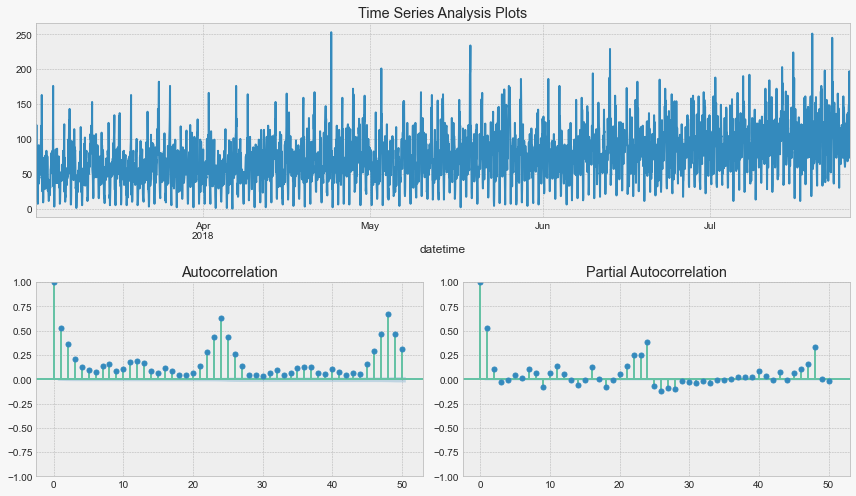

In [27]:
train_series = train.iloc[:,0]
tsplot(train_series, lags=50)

Исходный ряд стационарным не является. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

Критерий Дики-Фуллера: p=0.000075
Оптимальный параметр преобразования Бокса-Кокса: 0.661838


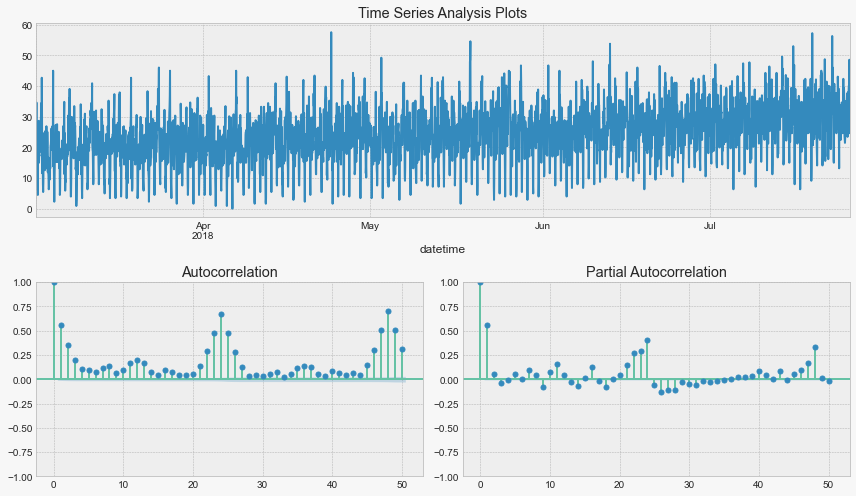

In [28]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


df = train_series.to_frame()
df['box'], lmbda = boxcox(df.iloc[:,0]+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(df['box'], lags=50)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Ок, дисперсию стабилизировали, но нужно еще убрать автокорреляцию с лагом сезонности 24.

Критерий Дики-Фуллера: p=0.000000


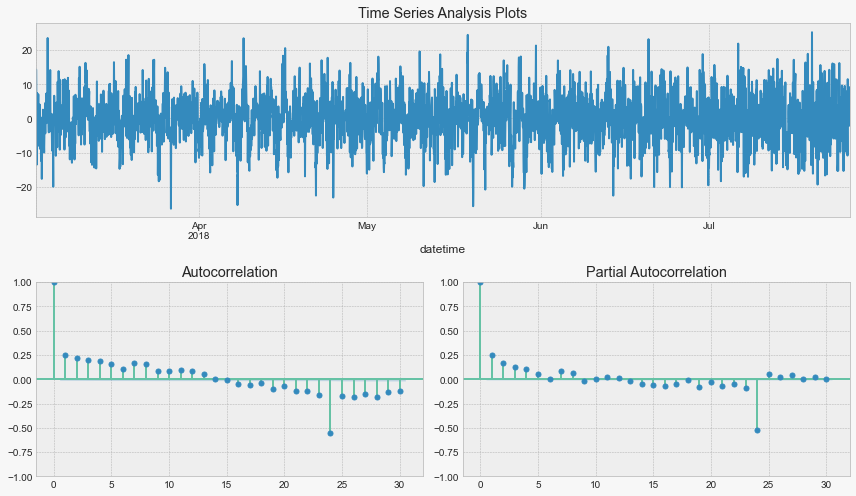

In [29]:
df['box_season'] = df['box'] - df['box'].shift(24)
tsplot(df['box_season'].iloc[24:], lags=30)

Ок, уже неплохо, можно еще поработать с лагом сезонной корреляции 24

Перебор гиперпараметров модели SARIMA

In [30]:
ps = range(1, 3) # AR
ds = range(0, 2) # diff
qs = range(0, 3) # MA
Ps = range(1, 3)
Ds = range(1, 2)
Qs = range(0, 3)

from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
print('Число вариантов', len(parameters_list))

Число вариантов 72


In [31]:
# Оставим только те варианты, у кого число параметров не более 5
## (иначе слишком долго будет все считаться)

p_list = []
for p in parameters_list:
    if sum(p) <= 5:
        p_list.append(p)
p_list

[(1, 0, 0, 1, 1, 0),
 (1, 0, 0, 1, 1, 1),
 (1, 0, 0, 1, 1, 2),
 (1, 0, 0, 2, 1, 0),
 (1, 0, 0, 2, 1, 1),
 (1, 0, 1, 1, 1, 0),
 (1, 0, 1, 1, 1, 1),
 (1, 0, 1, 2, 1, 0),
 (1, 0, 2, 1, 1, 0),
 (1, 1, 0, 1, 1, 0),
 (1, 1, 0, 1, 1, 1),
 (1, 1, 0, 2, 1, 0),
 (1, 1, 1, 1, 1, 0),
 (2, 0, 0, 1, 1, 0),
 (2, 0, 0, 1, 1, 1),
 (2, 0, 0, 2, 1, 0),
 (2, 0, 1, 1, 1, 0),
 (2, 1, 0, 1, 1, 0)]

In [32]:
%%time
results = []
best_aic = float("inf")

for param in notebook.tqdm(p_list):
    
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df['box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    aic = model.aic
    print(param, aic)
    
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  6%|██▍                                        | 1/18 [00:05<01:27,  5.13s/it]

(1, 0, 0, 1, 1, 0) 21811.98299625014


 11%|████▊                                      | 2/18 [00:20<03:01, 11.32s/it]

(1, 0, 0, 1, 1, 1) 20797.164192277945


 17%|███████▏                                   | 3/18 [01:33<09:52, 39.52s/it]

(1, 0, 0, 1, 1, 2) 20797.432418364126


 22%|█████████▌                                 | 4/18 [01:52<07:18, 31.31s/it]

(1, 0, 0, 2, 1, 0) 21423.23051615058


 28%|███████████▉                               | 5/18 [02:46<08:32, 39.42s/it]

(1, 0, 0, 2, 1, 1) 20798.991521293523


 33%|██████████████▎                            | 6/18 [02:54<05:45, 28.82s/it]

(1, 0, 1, 1, 1, 0) 21647.605945812804


 39%|████████████████▋                          | 7/18 [03:22<05:15, 28.64s/it]

(1, 0, 1, 1, 1, 1) 20591.492202066634


 44%|███████████████████                        | 8/18 [03:54<04:56, 29.68s/it]

(1, 0, 1, 2, 1, 0) 21238.650740947654


 50%|█████████████████████▌                     | 9/18 [04:05<03:33, 23.78s/it]

(1, 0, 2, 1, 1, 0) 21649.555808781042


 56%|███████████████████████▎                  | 10/18 [04:10<02:23, 17.90s/it]

(1, 1, 0, 1, 1, 0) 22673.665348436516


 61%|█████████████████████████▋                | 11/18 [04:28<02:05, 17.98s/it]

(1, 1, 0, 1, 1, 1) 21582.93079887834


 67%|████████████████████████████              | 12/18 [04:47<01:50, 18.33s/it]

(1, 1, 0, 2, 1, 0) 22215.972401701896


 72%|██████████████████████████████▎           | 13/18 [04:58<01:19, 15.96s/it]

(1, 1, 1, 1, 1, 0) 21756.3305627699


 78%|████████████████████████████████▋         | 14/18 [05:05<00:54, 13.51s/it]

(2, 0, 0, 1, 1, 0) 21751.098333311435


 83%|███████████████████████████████████       | 15/18 [05:28<00:48, 16.31s/it]

(2, 0, 0, 1, 1, 1) 20717.819147308517


 89%|█████████████████████████████████████▎    | 16/18 [05:51<00:36, 18.15s/it]

(2, 0, 0, 2, 1, 0) 21341.14630355202


 94%|███████████████████████████████████████▋  | 17/18 [06:04<00:16, 16.54s/it]

(2, 0, 1, 1, 1, 0) 21649.557179273892


100%|██████████████████████████████████████████| 18/18 [06:12<00:00, 20.72s/it]

(2, 1, 0, 1, 1, 0) 22315.203813534492
            parameters        aic
6   (1, 0, 1, 1, 1, 1) 20,591.492
14  (2, 0, 0, 1, 1, 1) 20,717.819
1   (1, 0, 0, 1, 1, 1) 20,797.164
2   (1, 0, 0, 1, 1, 2) 20,797.432
4   (1, 0, 0, 2, 1, 1) 20,798.992
CPU times: total: 12min 3s
Wall time: 6min 12s


посмотрим на CF и ACF остатков

C:\Users\ink\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Критерий Дики-Фуллера: p=0.000000


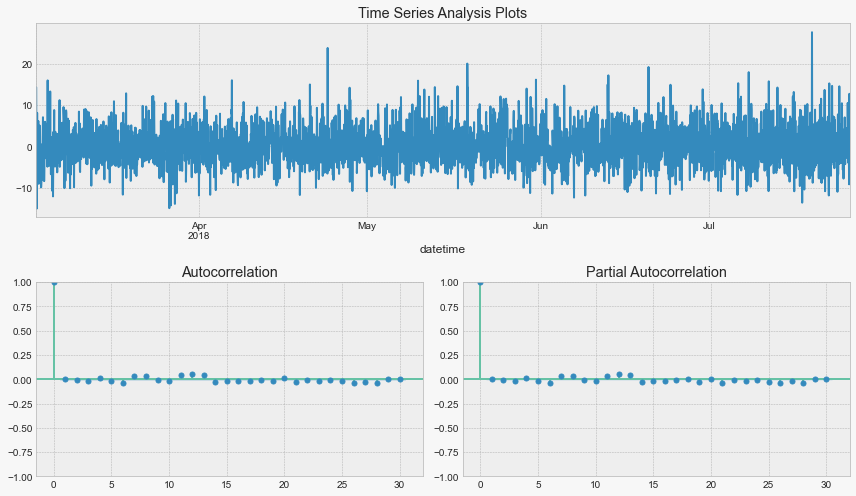

In [33]:
# посмотрим на CF и ACF остатков
tsplot(best_model.resid[24:], lags=30)

судя по CF и ACF остатки ряда стали стационарными

In [34]:
%%time
best_model = SARIMAX(df['box'], order=(1, 0, 1), 
                                        seasonal_order=(2, 1, 0, 24)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 box   No. Observations:                 3508
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 24)   Log Likelihood              -10614.325
Date:                             Tue, 28 Jun 2022   AIC                          21238.651
Time:                                     17:06:50   BIC                          21269.430
Sample:                                 03-02-2018   HQIC                         21249.638
                                      - 07-26-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.017     52.284      0.000       0.870       0.938
ma.L1         -0.7672      

Судя по коэффициентам модели, они все имеют крайне низкую вероятность, что истинные коэффициенты равны нулю. В целом хорошая модель.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Т.е. значимые коэффициенты. Понятно!

Будем прогнозировать на 1 шаг вперед на валидационном фолде, каждый раз обучая модель

100%|██████████████████████████████████████| 703/703 [5:12:30<00:00, 26.67s/it]


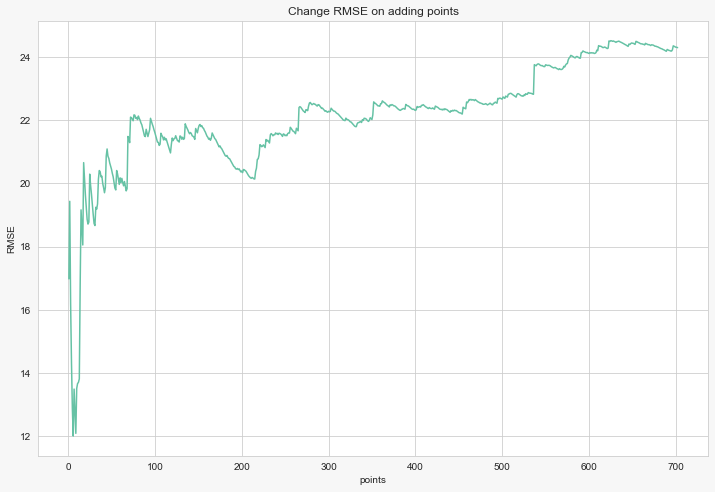

RMSE: 24.26995610073549
MAE: 18.462136613588612
MeanError: 1.623821148915095


In [69]:
# Запуск занимает около 5 часов. Заблокировал ячейку на автозапуск, чтобы каждый пересчет не занимал 5-6 часов
# код работает. Для проверки нужно разблокировать False на True
if False:
    valid_forecast = []
    for i in notebook.tqdm(range(valid_start, test_start)):
        ts = y.iloc[:i]
        ts_box, lmbda = boxcox(ts + 1) # прибавляем единицу, так как в исходном ряде есть нули
        best_model = SARIMAX(ts_box, order=(1, 0, 1), 
                                            seasonal_order=(1, 1, 1, 24)).fit(disp=-1)
        prediction = invboxcox(best_model.predict(start = i, end = i), lmbda)-1
        valid_forecast.append([y.iloc[i], prediction[0]])
        # из-за проблем с выделением оперативной памяти, приходится чистить переменные
        del best_model
        del ts_box
        del ts
        del prediction
    plot_cum_rmse(pd.DataFrame(valid_forecast))

Сохраненные итоги расчетов SARIMAX
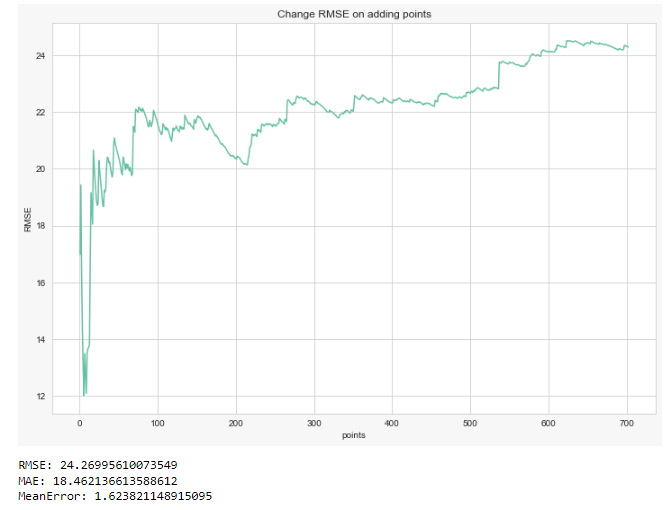

### Holt Winters

Попробуем спрогнозировать ряд на 1 шаг вперед тройным ES (Holt-Winters)

In [52]:
import warnings
warnings.filterwarnings("ignore")

  0%|          | 0/383 [00:00<?, ?it/s]

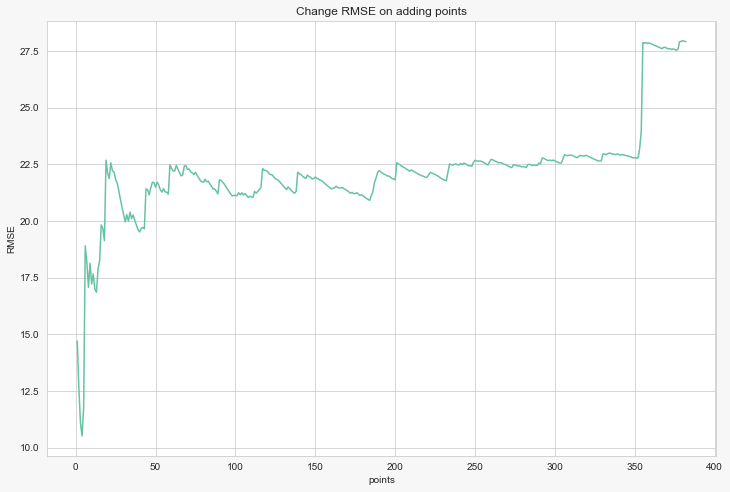

RMSE: 27.872411594848767
MAE: 18.73878348917269
MeanError: 3.449063125895184


In [58]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='multiplicative',
        seasonal = 'multiplicative',
        seasonal_periods=PERIOD,
        initialization_method="estimated",
        use_boxcox=False,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)-1
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

Попробуем не мультипликативную модель, а аддитивную, но с преобразованием BoxCox

  0%|          | 0/184 [00:00<?, ?it/s]

RMSE: 34.489599624891014
MAE: 22.277185961084452
MeanError: 4.3048676729056305


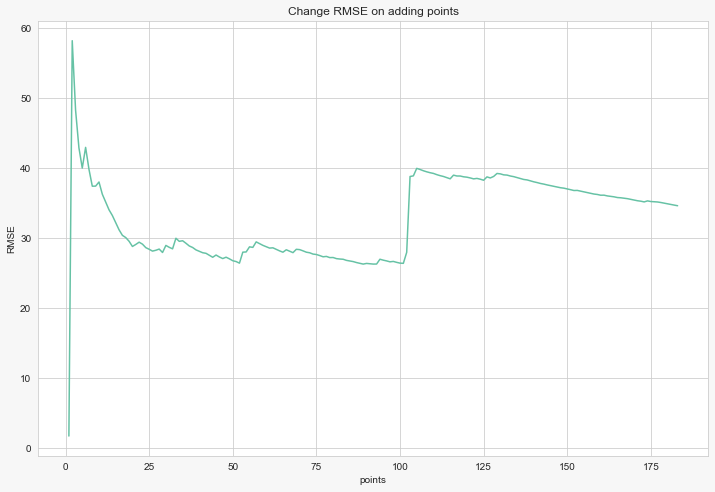

In [164]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='add',
        seasonal = 'add',
        seasonal_periods=PERIOD,
        initialization_method="estimated",
        use_boxcox=True,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)-1
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### STL Forecast

Перед прогнозированием STLForecast попробуем посмотреть каким сильным должно быть сглаживание, чтобы тренд был трендом сглаженным достаточно сильно и сезонность менялась не сильно быстро (но при этом мы допускаем что сезонность может плавно изменяться)

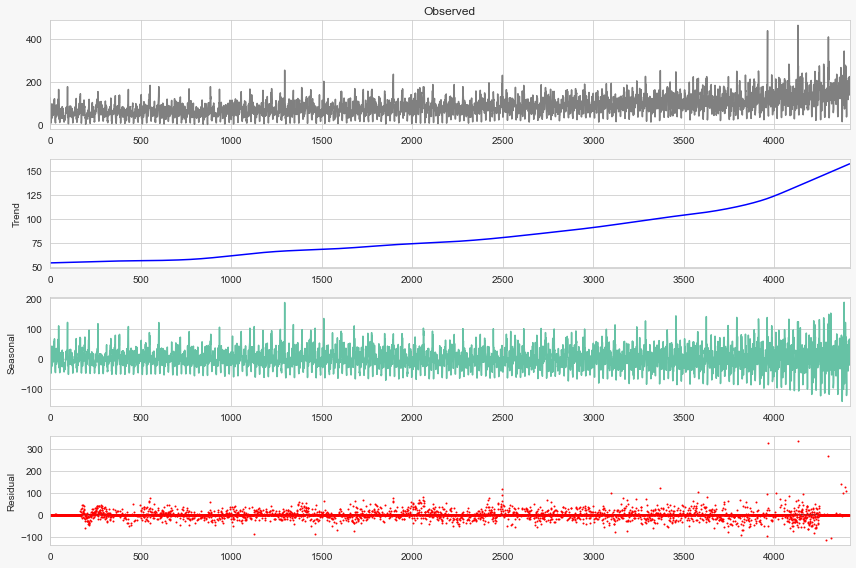

In [88]:
stl_decomposed = STL(
    endog=data.iloc[:,0].values, 
    period=PERIOD, 
    seasonal=5, 
    trend=1+30*24, 
    low_pass=1+1*PERIOD, 
    seasonal_deg=1, 
    trend_deg=1, 
    low_pass_deg=1, 
    robust=True
).fit()

fig = stl_decomposed.plot()
fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)
plt.show()

Теперь запускаем две STLForecast модели: одна на ARIMA, вторая на ExponentialSmoothing.

Как и ранее, прогноз делаем на 1 шаг вперед.

  0%|          | 0/383 [00:00<?, ?it/s]

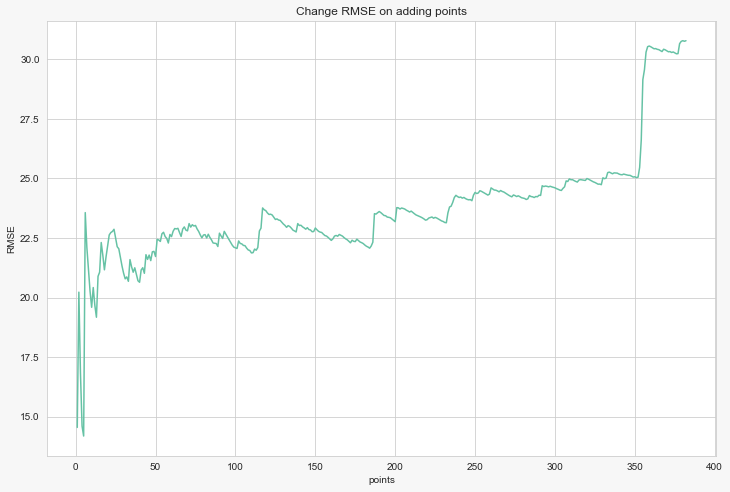

RMSE: 30.755409781039386
MAE: 21.49107669263614
MeanError: 0.13207507090920195


In [89]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = STLForecast(
        endog=y.iloc[:i],
        model=ARIMA,
        model_kwargs={"order": (2, 1, 0)},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()
    #(endog, model, *, model_kwargs=None, period=None, seasonal=7, trend=None, low_pass=None, seasonal_deg=1, trend_deg=1, low_pass_deg=1, robust=False, seasonal_jump=1, trend_jump=1, low_pass_jump=1)
    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))



  0%|          | 0/383 [00:00<?, ?it/s]

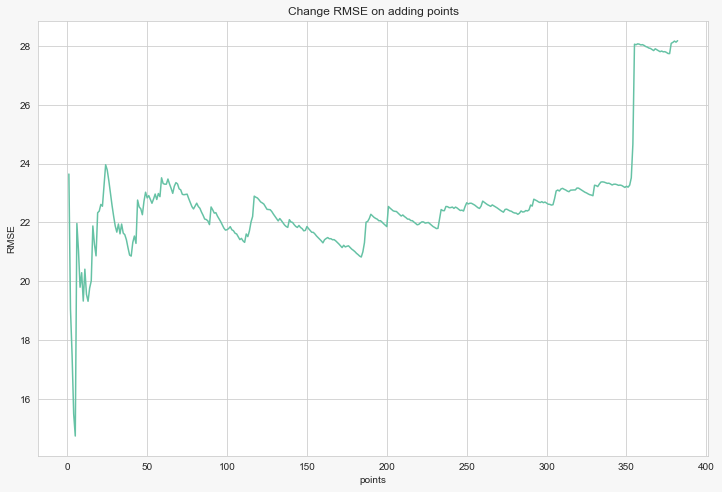

RMSE: 28.15799145899113
MAE: 19.45166654382875
MeanError: 1.0515619635715123


In [90]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = STLForecast(
        endog=y.iloc[:i], 
        model=ExponentialSmoothing, 
        model_kwargs={"trend": 'add'},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()

    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 28.26310240731604
MAE: 19.467903338946293
MeanError: 1.6949979459171318


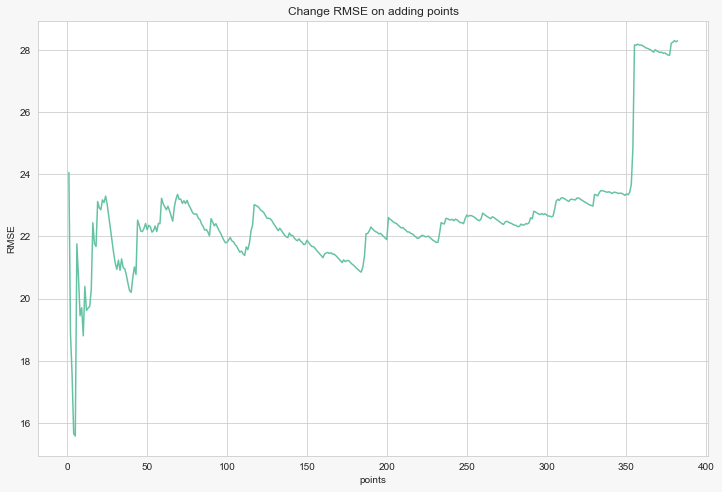

In [195]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
#     df = train_series.to_frame()
    y_box, lmbda = boxcox(y.iloc[:i]+1) # прибавляем единицу, так как в исходном ряде есть нули
    # fit model
    model_fit = STLForecast(
        endog=y_box, 
        model=ExponentialSmoothing, 
        model_kwargs={"trend": 'add'},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()

    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], inv_boxcox(prediction[0], lmbda)-1])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### Facebook Prophet

In [45]:
# pip install prophet

  0%|          | 0/383 [00:00<?, ?it/s]

16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing
16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:29 - cmdstanpy - INFO - Chain [1] start processing
16:18:29 - cmdstanpy - INFO - Chain [1] done processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:46 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1]

16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:55 - cmdstanpy - INFO - Chain [1] done processing
16:22:58 - cmdstanpy - INFO - Chain [1] start processing
16:22:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:07 - cmdstanpy - INFO - Chain [1] start processing
16:23:07 - cmdstanpy - INFO - Chain [1] done processing
16:23:12 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:19 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing
16:23:24 - cmdstanpy - INFO - Chain [1] start processing
16:23:24 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] 

16:27:36 - cmdstanpy - INFO - Chain [1] done processing
16:27:39 - cmdstanpy - INFO - Chain [1] start processing
16:27:39 - cmdstanpy - INFO - Chain [1] done processing
16:27:44 - cmdstanpy - INFO - Chain [1] start processing
16:27:45 - cmdstanpy - INFO - Chain [1] done processing
16:27:51 - cmdstanpy - INFO - Chain [1] start processing
16:27:52 - cmdstanpy - INFO - Chain [1] done processing
16:27:57 - cmdstanpy - INFO - Chain [1] start processing
16:27:57 - cmdstanpy - INFO - Chain [1] done processing
16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:02 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing
16:28:10 - cmdstanpy - INFO - Chain [1] start processing
16:28:10 - cmdstanpy - INFO - Chain [1] done processing
16:28:14 - cmdstanpy - INFO - Chain [1] start processing
16:28:14 - cmdstanpy - INFO - Chain [1] done processing
16:28:17 - cmdstanpy - INFO - Chain [1] 

16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:02 - cmdstanpy - INFO - Chain [1] done processing
16:33:05 - cmdstanpy - INFO - Chain [1] start processing
16:33:06 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:13 - cmdstanpy - INFO - Chain [1] start processing
16:33:13 - cmdstanpy - INFO - Chain [1] done processing
16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing
16:33:20 - cmdstanpy - INFO - Chain [1] start processing
16:33:21 - cmdstanpy - INFO - Chain [1] done processing
16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:28 - cmdstanpy - INFO - Chain [1] done processing
16:33:32 - cmdstanpy - INFO - Chain [1] 

16:37:41 - cmdstanpy - INFO - Chain [1] done processing
16:37:45 - cmdstanpy - INFO - Chain [1] start processing
16:37:45 - cmdstanpy - INFO - Chain [1] done processing
16:37:49 - cmdstanpy - INFO - Chain [1] start processing
16:37:49 - cmdstanpy - INFO - Chain [1] done processing
16:37:52 - cmdstanpy - INFO - Chain [1] start processing
16:37:53 - cmdstanpy - INFO - Chain [1] done processing
16:37:56 - cmdstanpy - INFO - Chain [1] start processing
16:37:57 - cmdstanpy - INFO - Chain [1] done processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:01 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:05 - cmdstanpy - INFO - Chain [1] done processing
16:38:09 - cmdstanpy - INFO - Chain [1] start processing
16:38:09 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:16 - cmdstanpy - INFO - Chain [1] 

16:42:24 - cmdstanpy - INFO - Chain [1] done processing
16:42:27 - cmdstanpy - INFO - Chain [1] start processing
16:42:28 - cmdstanpy - INFO - Chain [1] done processing
16:42:31 - cmdstanpy - INFO - Chain [1] start processing
16:42:31 - cmdstanpy - INFO - Chain [1] done processing
16:42:35 - cmdstanpy - INFO - Chain [1] start processing
16:42:35 - cmdstanpy - INFO - Chain [1] done processing
16:42:39 - cmdstanpy - INFO - Chain [1] start processing
16:42:40 - cmdstanpy - INFO - Chain [1] done processing
16:42:43 - cmdstanpy - INFO - Chain [1] start processing
16:42:44 - cmdstanpy - INFO - Chain [1] done processing
16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:42:48 - cmdstanpy - INFO - Chain [1] done processing
16:42:51 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:56 - cmdstanpy - INFO - Chain [1] start processing
16:42:56 - cmdstanpy - INFO - Chain [1] done processing
16:43:00 - cmdstanpy - INFO - Chain [1] 

RMSE: 46.35053025352565
MAE: 34.659795838958104
MeanError: 0.9291908400074853


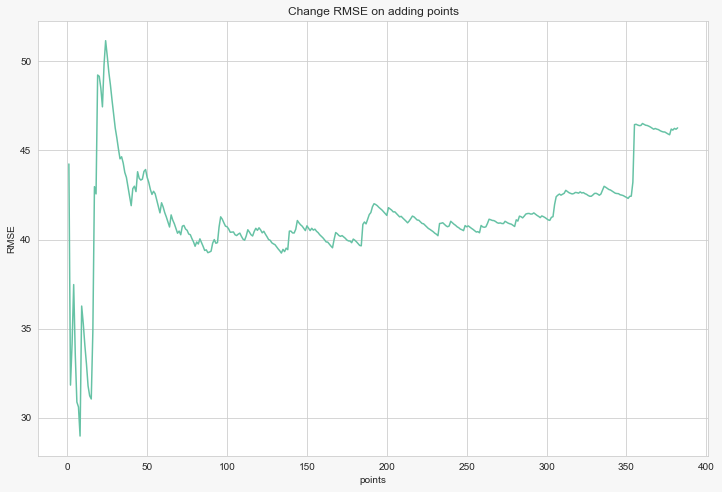

In [198]:
t = pd.DataFrame(data={'ds': y.index, 'y': y.values})

valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):

    # used like
    model_fit = Prophet(seasonality_mode = 'multiplicative').fit(t.iloc[:i,:])
    future = model_fit.make_future_dataframe(periods=1, freq='h')
    # make prediction
    prediction = model_fit.predict(future)
    valid_forecast.append([t.iloc[i,1], prediction.iloc[i,1], prediction.loc[i,'yhat_lower'], prediction.loc[i,'yhat_upper']])

t = pd.DataFrame(valid_forecast, columns=['y', 'y_hat', 'yhat_lower', 'yhat_upper'])

plot_cum_rmse(pd.DataFrame(valid_forecast))

На валидации получили следующие результаты:



model | n_iter | time | RMSE | MAE | MeanError
:- | :-: | :-: | :-: | :-: | :-: 
LinearRegression | 383 | 0:00:06 | 31.213 | 21.900 | -0.117
LGBM | 383 | 0:01:31 | 30.704 | 21.058 | 1.966
**SARIMAX** | - | - | - | - | -
Holt-Winters (M+M) | 383 | 0:23:37 | 27.876 | 18.737 | 3.427
**Holt-Winters (box+A+A)** | 383 | 0:15:29 | 27.865 | 18.817 | 1.972
STLForecast (ARIMA) | 383 | 0:43:31 | 32.851 | 22.922 | 0.269
STLForecast (ES) | 383 | 0:43:03 | 32.248 | 22.685 | 0.397
STLForecast (box+ES) | 383 | 0:41:45 | 25.813 | 22.734 | 0.837
Facebook Prophet | 383 | 1:12:412 | 46.383 | 34.718 | 0.194




Хорошо себя показали на валидации `Holt-Winters (box+A+A)` и `STLForecast (box+ES)`, у них несмещенный прогноз (низкое MeanError), низкая RMSE, приемлемое время

SARIMAX  также показал хорошие результаты, но его долгое время работы, требовательность к ресурсам памяти и большее смещение прогноза вынуждает предпочесть более быструю модель того же качества

Для теста выбираем `Holt-Winters (box+A+A)` она лучше всех остальных моделей по RMSE, быстрое время прогона валидации (15 мин), несмещенная ошибка

Facebook Prophet разочаровал. Я про него только недавно узнал (ранее сталкивался с SARIMA, ES (H-W), STL

## Тестирование

На валидации победил Holt-Winters с прогнозированием через аддтитивные тренд и сезонность и с преобразованием boxCox.

Запускаем прогон модели на тесте. Прогнозируем как и ранее на 1 шаг вперед

100%|████████████████████████████████████████| 879/879 [23:08<00:00,  1.58s/it]


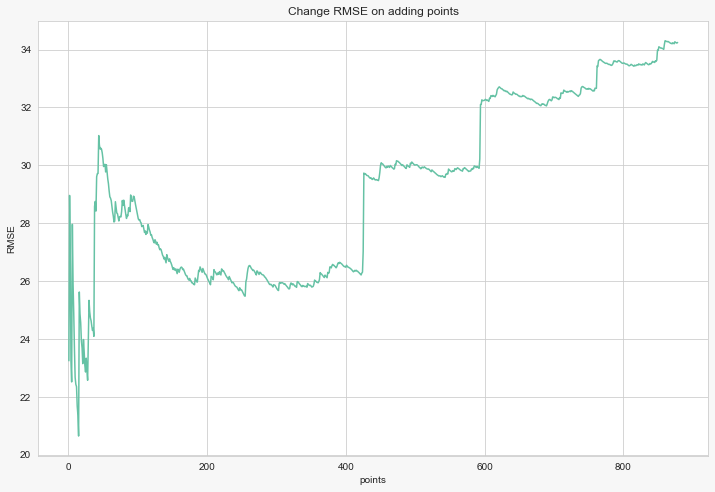

RMSE: 34.22704971593835
MAE: 24.68809119397397
MeanError: 1.276735278988884


In [48]:
test_forecast = []
for i in notebook.tqdm(range(test_start, N)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='add',
        seasonal = 'add',
        seasonal_periods=PERIOD,
        use_boxcox=True,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)
    test_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(test_forecast))

По графику накопительной RMSE видно, что RMSE скачкообразно выросла после 4 наблюдений, это выбросы, которые скачком подняли RMSE примерно на 8 единиц. Плохо, что тест оказался с выбросами и RMSE на тесте не сравним с RMSE на валидации. Во всяком случае то, что на тесте получилось RMSE существенно выше не результат переобучения, а влияние выбросов и следствие неадекватной тестовой выборки

Построим график прогноза и фактических данных на тесте

<AxesSubplot:>

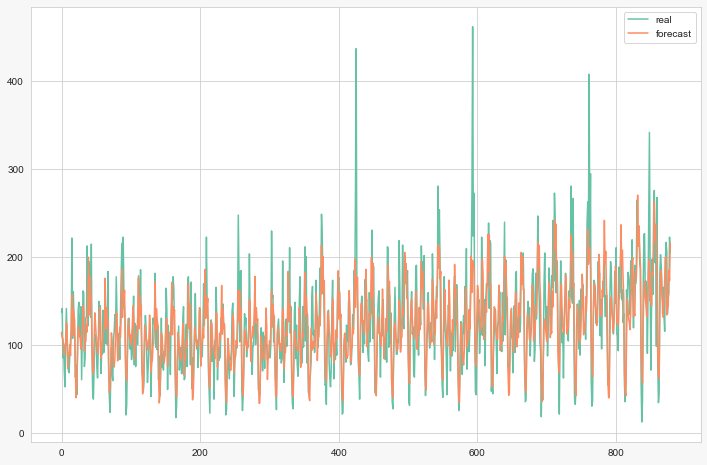

In [49]:
rdf = pd.DataFrame(test_forecast, columns=['real', 'forecast'])
rdf.plot()

Построим за последнюю неделю еще

<AxesSubplot:>

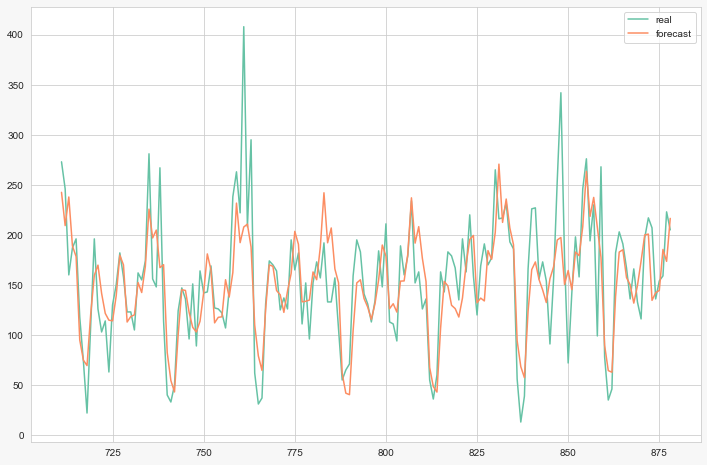

In [50]:
rdf[-24*7:].plot()

Основные промахи, это пиковые всплески. Их мы не угадаем никак, этих данных нет в истории, с этими ошибками только смириться нужно. В основном модель хорошо угадывает и сезонность и среднй уровень.

## ВЫВОД

Загрузив данные, выяснили, что они полные, есть один интервал в час с нулевым значением
Провели тесты ADF и KPSS, которые дали противоположные результаты относительно стациолнарности ряда около тренда. Построили спректр ряда с использованием быстрого преобразования Фурье (FFT), выделив основной цикл 24ч.

Были построены несколько моделей, прогнозирующие на 1 шаг(час) вперед: LinearRegression/LGBM с фичами, SARIMAX, Holt-Winters, STLForecast, Facebook Prophet

Лучшей на валидации по RMSE оказалась Holt-Winters с прогнозированием через аддтитивные тренд и сезонность и с преобразованием boxCox.

На тесте лучшая модель показала RMSE 34 (baseline RMSE 48)

## Рекомендации
* Убрать из теста выбросы, возможно есть внешние причины, давшие 4 существенных пика
* попробовать стековать модели
* попробовать последовательно применять модели (ES и затем ARIMA к остаткам)
* Попробовать нейронные модели